In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

C:\Users\indir\AppData\Local\Temp\ipykernel_14832\3315849315.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:
def parser(s):
    return datetime.strptime(s,'%Y-%m-%d')

In [4]:
production_ice_cream=pd.read_csv(r"C:\Users\indir\Downloads\ice_cream.csv",parse_dates=[0],index_col=0, squeeze=True, date_parser=parser)

C:\Users\indir\AppData\Local\Temp\ipykernel_14832\2073382064.py:1: FutureWarning: The squeeze argument has been deprecated and will be removed in a future version. Append .squeeze("columns") to the call to squeeze.


  production_ice_cream=pd.read_csv(r"C:\Users\indir\Downloads\ice_cream.csv",parse_dates=[0],index_col=0, squeeze=True, date_parser=parser)


In [5]:
production_ice_cream.rename('production', inplace= True)

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Name: production, Length: 577, dtype: float64

In [6]:
production_ice_cream=production_ice_cream.asfreq(pd.infer_freq(production_ice_cream.index))

In [7]:
start_date=pd.to_datetime('2010-01-01')
production_ice_cream=production_ice_cream[start_date:]

In [8]:
production_ice_cream

DATE
2010-01-01     91.2895
2010-02-01    110.4994
2010-03-01    127.0971
2010-04-01    132.6468
2010-05-01    134.5576
                ...   
2019-09-01    100.1741
2019-10-01     90.1684
2019-11-01     79.7223
2019-12-01     75.7094
2020-01-01     83.6290
Freq: MS, Name: production, Length: 121, dtype: float64

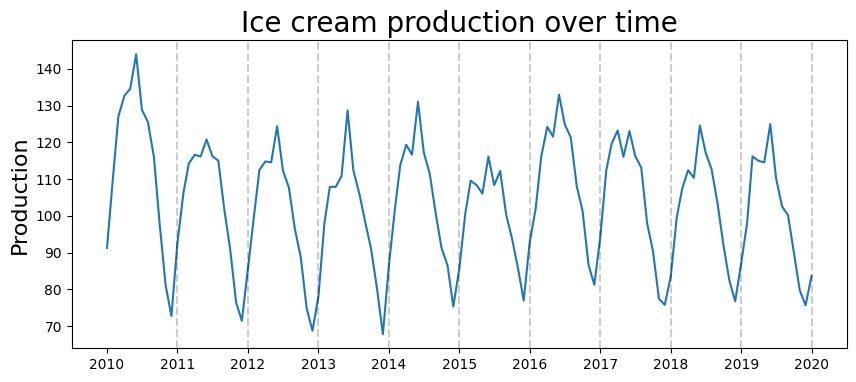

In [9]:
plt.figure(figsize=(10,4))
plt.plot(production_ice_cream)
plt.title('Ice cream production over time', fontsize=20)
plt.ylabel('Production', fontsize=16)
for year in range(2011,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)


Kinda seasonal- will look at PACF to check which lags to use for AR model

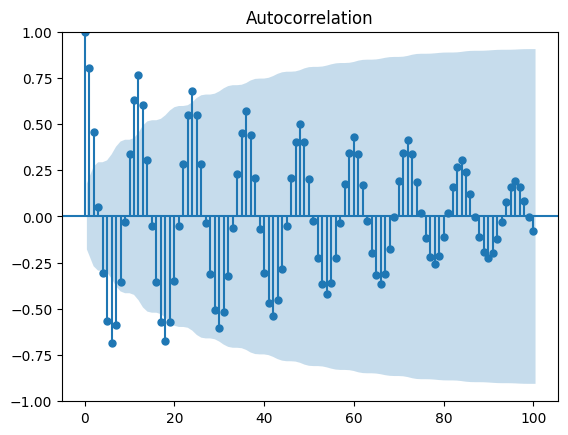

In [10]:
acf_plot=plot_acf(production_ice_cream, lags=100) 

C:\Users\indir\AppData\Local\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


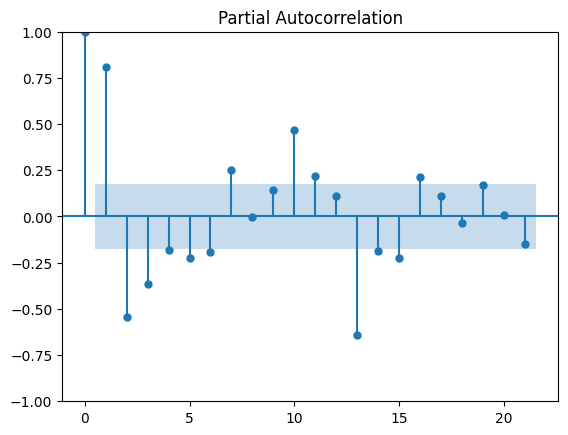

In [11]:
pacf_plot=plot_pacf(production_ice_cream)


Visually- significant lags seem to be 1,2,3,5,7,10,13

We will first check AR(3) Model

In [12]:
train_end=datetime(2018,12,1)
test_end=datetime(2019,12,1)

train_data=production_ice_cream[:train_end]
test_data=production_ice_cream[train_end+timedelta(days=1):test_end]

In [13]:
model=ARIMA(train_data,order=(3,0,0))

In [14]:
start=time()
model_fit=model.fit()
end=time()
print("Model fitting time", end-start)

Model fitting time 0.1576089859008789


In [15]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -374.085
Date:                Sun, 01 Jun 2025   AIC                            758.170
Time:                        12:20:28   BIC                            771.580
Sample:                    01-01-2010   HQIC                           763.607
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.5743      2.169     47.761      0.000      99.324     107.825
ar.L1          1.0469      0.102     10.256      0.000       0.847       1.247
ar.L2         -0.0523      0.175     -0.298      0.7

In [16]:
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
predictions=model_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data-predictions

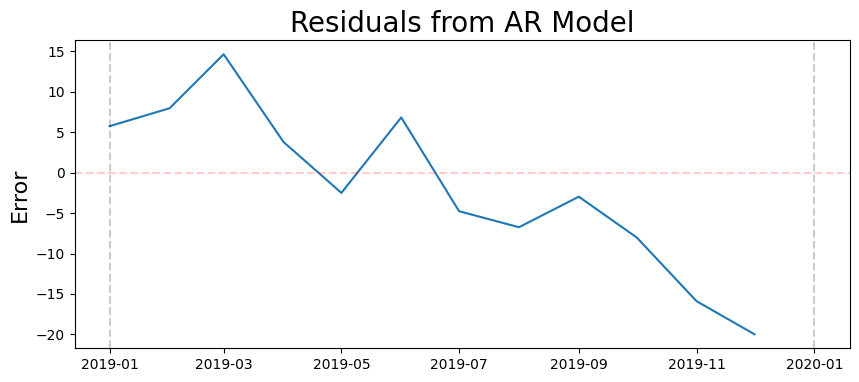

In [17]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error',fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    

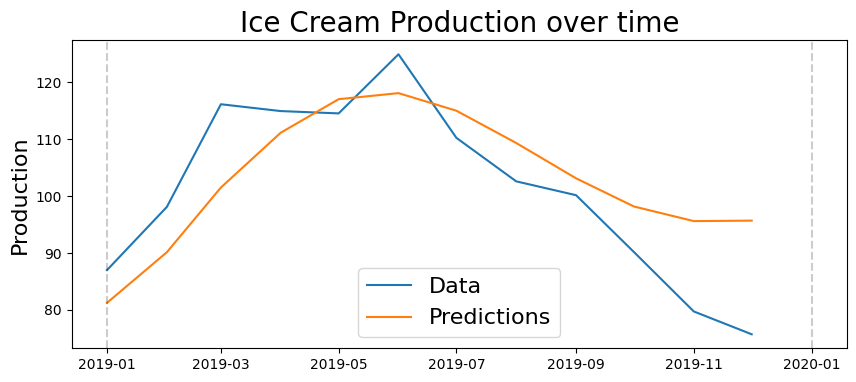

In [18]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'),fontsize=16)

plt.title('Ice Cream Production over time', fontsize=20)
plt.ylabel('Production',fontsize=16)
for year in range(2019,2021):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

    

In [19]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0895


In [20]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 9.884158746740638


We now try AR(7) model

In [21]:
model_1=ARIMA(train_data,order=(7,0,0))

In [27]:
start_1=time()
model_fit=model_1.fit()
end_1=time()
print('Model fitting time', end_1-start_1)

Model fitting time 0.134291410446167


In [28]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  108
Model:                 ARIMA(7, 0, 0)   Log Likelihood                -361.526
Date:                Sun, 01 Jun 2025   AIC                            741.051
Time:                        12:25:01   BIC                            765.191
Sample:                    01-01-2010   HQIC                           750.839
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.6216      1.339     77.406      0.000     100.998     106.245
ar.L1          0.9497      0.097      9.837      0.000       0.760       1.139
ar.L2         -0.0964      0.131     -0.735      0.4

In [29]:
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]
predictions=model_fit.predict(start=pred_start_date,end=pred_end_date)
residuals=test_data-predictions

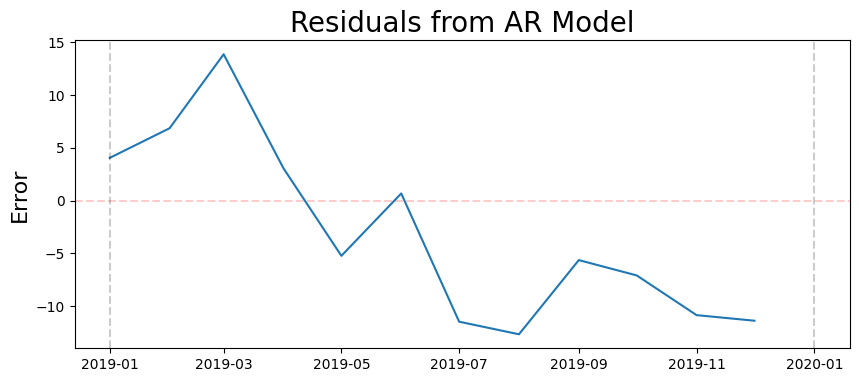

In [30]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error',fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)
for year in range(2019,2021):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
    

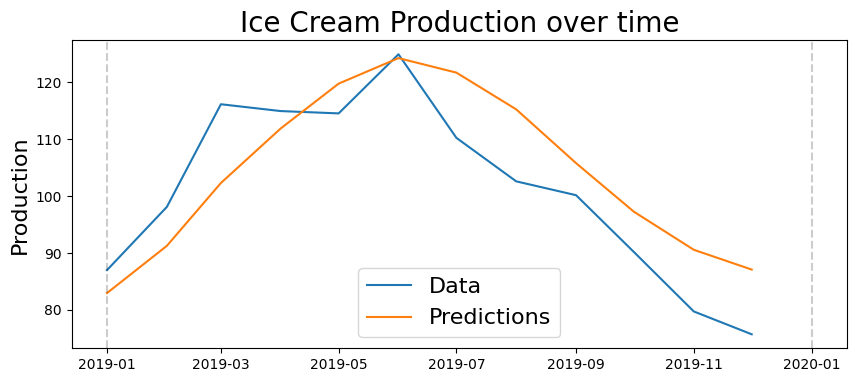

In [31]:
plt.figure(figsize=(10,4))

plt.plot(test_data)
plt.plot(predictions)

plt.legend(('Data','Predictions'),fontsize=16)

plt.title('Ice Cream Production over time', fontsize=20)
plt.ylabel('Production',fontsize=16)
for year in range(2019,2021):
        plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

    

In [32]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))

Mean Absolute Percent Error: 0.0802


In [33]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 8.725440372469029
